# Importação das bibliotecas necessárias

In [2]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from sklearn.utils import shuffle
from tqdm.notebook import tqdm_notebook
import mlflow
from mlflow import log_metric, log_param, log_artifact
from mlflow.pytorch import log_model
import nibabel as nib
from sklearn.utils import shuffle
from tensorflow.keras.backend import one_hot
from skimage.transform import resize

# Criação das rotinas de leitura de dados

In [3]:
def generate_train_files():
    from sklearn.utils import shuffle
    TRAIN_DIR = "/home/felipe-sassi/Code/BRATS_DATA_OFFICIAL/Data_Train/MICCAI_BraTS2020_TrainingData/"
    files = os.listdir(TRAIN_DIR)
    name_list = []
    for file in files:
        if (not (file.endswith(".csv"))):
            dir_temp = TRAIN_DIR + file
            files_inside = os.listdir(dir_temp)
            for i in files_inside:
                if i.split("_")[-1] in ["flair.nii.gz"]:
                    dir_final = dir_temp + "/" + i
                    name_list.append(dir_final)                    
    return name_list

In [4]:
files = generate_train_files()

In [5]:
class TrainDataLoader(Dataset):
    def __init__(self, files):
        self.files = files
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        dir = self.files[idx]
        file = dir.split("/")[-2].split("_")[-1]
        dir_seg  = '/home/felipe-sassi/Code/BRATS_DATA_OFFICIAL/Data_Train/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{}/BraTS20_Training_{}_seg.nii.gz' .format(file, file)
        x = nib.load(dir).get_fdata()
        x = ((x - x.mean())/(x.std() + 1e-6)).transpose(2, 0, 1)
        y = nib.load(dir_seg).get_fdata().transpose(2, 0, 1)
        y[y >= 1] = 1
        y = y.astype(np.uint8)
        y = torch.tensor(resize(y[15:143], (128, 128, 128))).unsqueeze(dim = 0).float()
        y[y != 0] = 1
        return torch.tensor(resize(x[15:143], (128, 128, 128))).unsqueeze(dim = 0).float(), y

# Fazer melhor

In [105]:
Data_Train = DataLoader(TrainDataLoader(files[:100]), 
                      batch_size = 1)
x_sum = np.zeros((128))
for x, y in tqdm_notebook(Data_Train):
    x_sum = x_sum + x[0, 0].numpy().sum(axis = (1, 2))

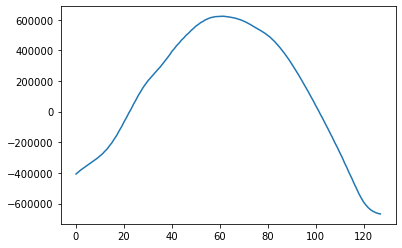

In [106]:
plt.plot(x_sum)

In [6]:
import torch.nn as nn
import torch

#https://arxiv.org/pdf/1802.10508.pdf

class Modified3DUNet(nn.Module):
    def __init__(self, in_channels, n_classes, base_n_filter = 8):
        super(Modified3DUNet, self).__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.base_n_filter = base_n_filter

        self.lrelu = nn.LeakyReLU()
        self.dropout3d = nn.Dropout3d(p=0.6)
        self.upsacle = nn.Upsample(scale_factor=2, mode='nearest')
        self.softmax = nn.Softmax(dim=1)

        # Level 1 context pathway
        self.conv3d_c1_1 = nn.Conv3d(self.in_channels, self.base_n_filter, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv3d_c1_2 = nn.Conv3d(self.base_n_filter, self.base_n_filter, kernel_size=3, stride=1, padding=1, bias=False)
        self.lrelu_conv_c1 = self.lrelu_conv(self.base_n_filter, self.base_n_filter)
        self.inorm3d_c1 = nn.InstanceNorm3d(self.base_n_filter)

        # Level 2 context pathway
        self.conv3d_c2 = nn.Conv3d(self.base_n_filter, self.base_n_filter*2, kernel_size=3, stride=2, padding=1, bias=False)
        self.norm_lrelu_conv_c2 = self.norm_lrelu_conv(self.base_n_filter*2, self.base_n_filter*2)
        self.inorm3d_c2 = nn.InstanceNorm3d(self.base_n_filter*2)

        # Level 3 context pathway
        self.conv3d_c3 = nn.Conv3d(self.base_n_filter*2, self.base_n_filter*4, kernel_size=3, stride=2, padding=1, bias=False)
        self.norm_lrelu_conv_c3 = self.norm_lrelu_conv(self.base_n_filter*4, self.base_n_filter*4)
        self.inorm3d_c3 = nn.InstanceNorm3d(self.base_n_filter*4)

        # Level 4 context pathway
        self.conv3d_c4 = nn.Conv3d(self.base_n_filter*4, self.base_n_filter*8, kernel_size=3, stride=2, padding=1, bias=False)
        self.norm_lrelu_conv_c4 = self.norm_lrelu_conv(self.base_n_filter*8, self.base_n_filter*8)
        self.inorm3d_c4 = nn.InstanceNorm3d(self.base_n_filter*8)

        # Level 5 context pathway, level 0 localization pathway
        self.conv3d_c5 = nn.Conv3d(self.base_n_filter*8, self.base_n_filter*16, kernel_size=3, stride=2, padding=1, bias=False)
        self.norm_lrelu_conv_c5 = self.norm_lrelu_conv(self.base_n_filter*16, self.base_n_filter*16)
        self.norm_lrelu_upscale_conv_norm_lrelu_l0 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter*16, self.base_n_filter*8)

        self.conv3d_l0 = nn.Conv3d(self.base_n_filter*8, self.base_n_filter*8, kernel_size = 1, stride=1, padding=0, bias=False)
        self.inorm3d_l0 = nn.InstanceNorm3d(self.base_n_filter*8)

        # Level 1 localization pathway
        self.conv_norm_lrelu_l1 = self.conv_norm_lrelu(self.base_n_filter*16, self.base_n_filter*16)
        self.conv3d_l1 = nn.Conv3d(self.base_n_filter*16, self.base_n_filter*8, kernel_size=1, stride=1, padding=0, bias=False)
        self.norm_lrelu_upscale_conv_norm_lrelu_l1 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter*8, self.base_n_filter*4)

        # Level 2 localization pathway
        self.conv_norm_lrelu_l2 = self.conv_norm_lrelu(self.base_n_filter*8, self.base_n_filter*8)
        self.conv3d_l2 = nn.Conv3d(self.base_n_filter*8, self.base_n_filter*4, kernel_size=1, stride=1, padding=0, bias=False)
        self.norm_lrelu_upscale_conv_norm_lrelu_l2 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter*4, self.base_n_filter*2)

        # Level 3 localization pathway
        self.conv_norm_lrelu_l3 = self.conv_norm_lrelu(self.base_n_filter*4, self.base_n_filter*4)
        self.conv3d_l3 = nn.Conv3d(self.base_n_filter*4, self.base_n_filter*2, kernel_size=1, stride=1, padding=0, bias=False)
        self.norm_lrelu_upscale_conv_norm_lrelu_l3 = self.norm_lrelu_upscale_conv_norm_lrelu(self.base_n_filter*2, self.base_n_filter)

        # Level 4 localization pathway
        self.conv_norm_lrelu_l4 = self.conv_norm_lrelu(self.base_n_filter*2, self.base_n_filter*2)
        self.conv3d_l4 = nn.Conv3d(self.base_n_filter*2, self.n_classes, kernel_size=1, stride=1, padding=0, bias=False)

        self.ds2_1x1_conv3d = nn.Conv3d(self.base_n_filter*8, self.n_classes, kernel_size=1, stride=1, padding=0, bias=False)
        self.ds3_1x1_conv3d = nn.Conv3d(self.base_n_filter*4, self.n_classes, kernel_size=1, stride=1, padding=0, bias=False)


    def conv_norm_lrelu(self, feat_in, feat_out):
        return nn.Sequential(
            nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm3d(feat_out),
            nn.LeakyReLU())

    def norm_lrelu_conv(self, feat_in, feat_out):
        return nn.Sequential(
            nn.InstanceNorm3d(feat_in),
            nn.LeakyReLU(),
            nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False))

    def lrelu_conv(self, feat_in, feat_out):
        return nn.Sequential(
            nn.LeakyReLU(),
            nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False))

    def norm_lrelu_upscale_conv_norm_lrelu(self, feat_in, feat_out):
        return nn.Sequential(
            nn.InstanceNorm3d(feat_in),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            # should be feat_in*2 or feat_in
            nn.Conv3d(feat_in, feat_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm3d(feat_out),
            nn.LeakyReLU())

    def forward(self, x):
        #  Level 1 context pathway
        out = self.conv3d_c1_1(x)
        residual_1 = out
        out = self.lrelu(out)
        out = self.conv3d_c1_2(out)
        out = self.dropout3d(out)
        out = self.lrelu_conv_c1(out)
        # Element Wise Summation
        out += residual_1
        context_1 = self.lrelu(out)
        out = self.inorm3d_c1(out)
        out = self.lrelu(out)

        # Level 2 context pathway
        out = self.conv3d_c2(out)
        residual_2 = out
        out = self.norm_lrelu_conv_c2(out)
        out = self.dropout3d(out)
        out = self.norm_lrelu_conv_c2(out)
        out += residual_2
        out = self.inorm3d_c2(out)
        out = self.lrelu(out)
        context_2 = out

        # Level 3 context pathway
        out = self.conv3d_c3(out)
        residual_3 = out
        out = self.norm_lrelu_conv_c3(out)
        out = self.dropout3d(out)
        out = self.norm_lrelu_conv_c3(out)
        out += residual_3
        out = self.inorm3d_c3(out)
        out = self.lrelu(out)
        context_3 = out

        # Level 4 context pathway
        out = self.conv3d_c4(out)
        residual_4 = out
        out = self.norm_lrelu_conv_c4(out)
        out = self.dropout3d(out)
        out = self.norm_lrelu_conv_c4(out)
        out += residual_4
        out = self.inorm3d_c4(out)
        out = self.lrelu(out)
        context_4 = out

        # Level 5
        out = self.conv3d_c5(out)
        residual_5 = out
        out = self.norm_lrelu_conv_c5(out)
        out = self.dropout3d(out)
        out = self.norm_lrelu_conv_c5(out)
        out += residual_5
        out = self.norm_lrelu_upscale_conv_norm_lrelu_l0(out)

        out = self.conv3d_l0(out)
        out = self.inorm3d_l0(out)
        out = self.lrelu(out)

        # Level 1 localization pathway
        out = torch.cat([out, context_4], dim=1)
        out = self.conv_norm_lrelu_l1(out)
        out = self.conv3d_l1(out)
        out = self.norm_lrelu_upscale_conv_norm_lrelu_l1(out)

        # Level 2 localization pathway
        out = torch.cat([out, context_3], dim=1)
        out = self.conv_norm_lrelu_l2(out)
        ds2 = out
        out = self.conv3d_l2(out)
        out = self.norm_lrelu_upscale_conv_norm_lrelu_l2(out)

        # Level 3 localization pathway
        out = torch.cat([out, context_2], dim=1)
        out = self.conv_norm_lrelu_l3(out)
        ds3 = out
        out = self.conv3d_l3(out)
        out = self.norm_lrelu_upscale_conv_norm_lrelu_l3(out)

        # Level 4 localization pathway
        out = torch.cat([out, context_1], dim=1)
        out = self.conv_norm_lrelu_l4(out)
        out_pred = self.conv3d_l4(out)

        ds2_1x1_conv = self.ds2_1x1_conv3d(ds2)
        ds1_ds2_sum_upscale = self.upsacle(ds2_1x1_conv)
        ds3_1x1_conv = self.ds3_1x1_conv3d(ds3)
        ds1_ds2_sum_upscale_ds3_sum = ds1_ds2_sum_upscale + ds3_1x1_conv
        ds1_ds2_sum_upscale_ds3_sum_upscale = self.upsacle(ds1_ds2_sum_upscale_ds3_sum)

        out = out_pred + ds1_ds2_sum_upscale_ds3_sum_upscale
        seg_layer = torch.sigmoid(out)
        return seg_layer

In [7]:
mlflow.set_tracking_uri("/home/felipe-sassi/mlruns")

## Dice

In [8]:
def dice_metric(y_true, y_predicted, thr=0.5):
    assert y_true.shape == y_predicted.shape
    try:
        y_true = y_true.clone()
        y_predicted = y_predicted.clone()
        batch_size = y_true.shape[0]
        y_true = y_true.contiguous().view(-1) 
        y_predicted = y_predicted.contiguous().view(-1)

        y_predicted[y_predicted < thr] = 0
        y_predicted[y_predicted >= thr] = 1 

        mult = 2*torch.sum(y_true*y_predicted)
        sum_1 = torch.sum(y_true)
        sum_2 = torch.sum(y_predicted)
        dice = mult/(sum_1 + sum_2 + 1e-6)
        return torch.mean(dice), torch.mean(dice, dim = 0)
    except:
        batch_size = y_true.shape[0]
        y_true = y_true.reshape(-1)
        y_predicted = y_predicted.reshape(-1)

        y_predicted[y_predicted < thr] = 0
        y_predicted[y_predicted >= thr] = 1 

        mult = 2*np.sum(y_true*y_predicted)
        sum_1 = np.sum(y_true)
        sum_2 = np.sum(y_predicted)
        dice = mult/(sum_1 + sum_2 + 1e-6)
        return np.mean(dice)

In [54]:
def soft_dice(y_true, y_predicted):
    
    assert len(y_true.shape) == 5
    assert len(y_predicted.shape) == 5
    assert y_true.shape == y_predicted.shape
    y_true = y_true.clone()
    y_predicted = y_predicted.clone()
    dim_1 = y_true.shape[0]
    y_true = y_true.contiguous().view(-1)
    y_predicted = y_predicted.contiguous().view(-1)
    mult = 2*torch.sum(y_true*y_predicted)
    sum_1 = torch.sum(torch.pow(y_true, 2))
    sum_2 = torch.sum(torch.pow(y_predicted, 2))
    dice = (mult + 1)/(sum_1 + sum_2 + 1)    
    return 1 - dice

In [108]:
def train_and_validate_model(loss, files, epochs=10, learning_rate=1e-3):
    files = shuffle(files, random_state = 0)    
    UNet = Modified3DUNet(1, 1).to("cuda:0")
    Data_Train = DataLoader(TrainDataLoader(files[:270]), 
                      batch_size = 1)
    Data_Val = DataLoader(TrainDataLoader(files[270:]), 
                      batch_size = 1)
    Epochs = epochs
    lr = learning_rate
    Optimizer = optim.Adam(UNet.parameters(), lr = lr)
#     patience = 3
#     factor = 0.1
#     threshold = 0.01
    # LR_Scheduler = optim.lr_scheduler.ReduceLROnPlateau(Optimizer, patience = patience, threshold = threshold)
    print(f"Start training for {Epochs} epochs.")
    Loss = loss
    with mlflow.start_run(): 
        log_param("Model", "3D UNet")
        log_param("Learning Rate", learning_rate)
        log_param("Epochs", epochs)
        for e in range(Epochs):
            Total_Loss = 0
            Dice_Score = 0
            Dice_Score_Channel = np.zeros(1)
            for x, y in tqdm_notebook(Data_Train):
                x, y = x.to("cuda:0"), y.to("cuda:0")
                Optimizer.zero_grad()
                y_predicted = UNet(x)
                Loss_Value = Loss(y_predicted, y)
                Loss_Value.backward()
                Optimizer.step()
                Total_Loss = Total_Loss + Loss_Value.item()
                Dice_Score = Dice_Score + dice_metric(y.detach().cpu().numpy(), y_predicted.detach().cpu().numpy())
            log_metric("Dice Train Mean ", Dice_Score/270, step = e)    
            log_metric("Loss Train", Total_Loss/270, step = e)
            print("Dice score train {}: {}" .format(e, Dice_Score/270))
            Dice_Score = 0
            Total_Loss = 0
            for x, y in tqdm_notebook(Data_Val):
                x, y = x.to("cuda:0"), y.to("cuda:0")
                y_predicted = UNet(x)
                Total_Loss = Total_Loss + Loss(y_predicted, y).item()
                Dice_Score = Dice_Score + dice_metric(y.detach().cpu().numpy(), y_predicted.detach().cpu().numpy())
            log_metric("Dice Validation Mean ", Dice_Score/99, step = e)       
            log_metric("Loss Validation", Total_Loss/99, step = e)
            print("Dice score validation {}: {}" .format(e, Dice_Score/99))
        log_model(UNet, "Model Trained")
    return UNet

In [109]:
def plot_results(model, patient):
    plt.figure(figsize = (20, 120))
    Data_Val = DataLoader(TrainDataLoader([files[patient]]), 
                      batch_size = 1)
    for x, y in Data_Val:
        x, y = x.to("cuda:0"), y.to("cuda:0")
        y_predicted = model(x)
    for i in range(60):
        idx = 40 + i
        plt.subplot(60, 3, 3*i + 1)
        plt.imshow(x[0, 0, idx].cpu().numpy())
        plt.axis("off")
        plt.subplot(60, 3, 3*i + 2)
        plt.imshow(y[0, 0, idx].cpu().detach().numpy())
        plt.axis("off")
        plt.subplot(60, 3, 3*i + 3)
        y_p = y_predicted[0, 0, idx].cpu().detach().numpy().copy()
        y_p[y_p < 0.5] = 0
        y_p[y_p >= 0.5] = 1
        plt.imshow(y_p)
        plt.axis("off")

In [ ]:
%%capture
UNet_1 = train_and_validate_model(soft_dice, learning_rate = 1e-5, epochs = 25, files, epochs = 30)

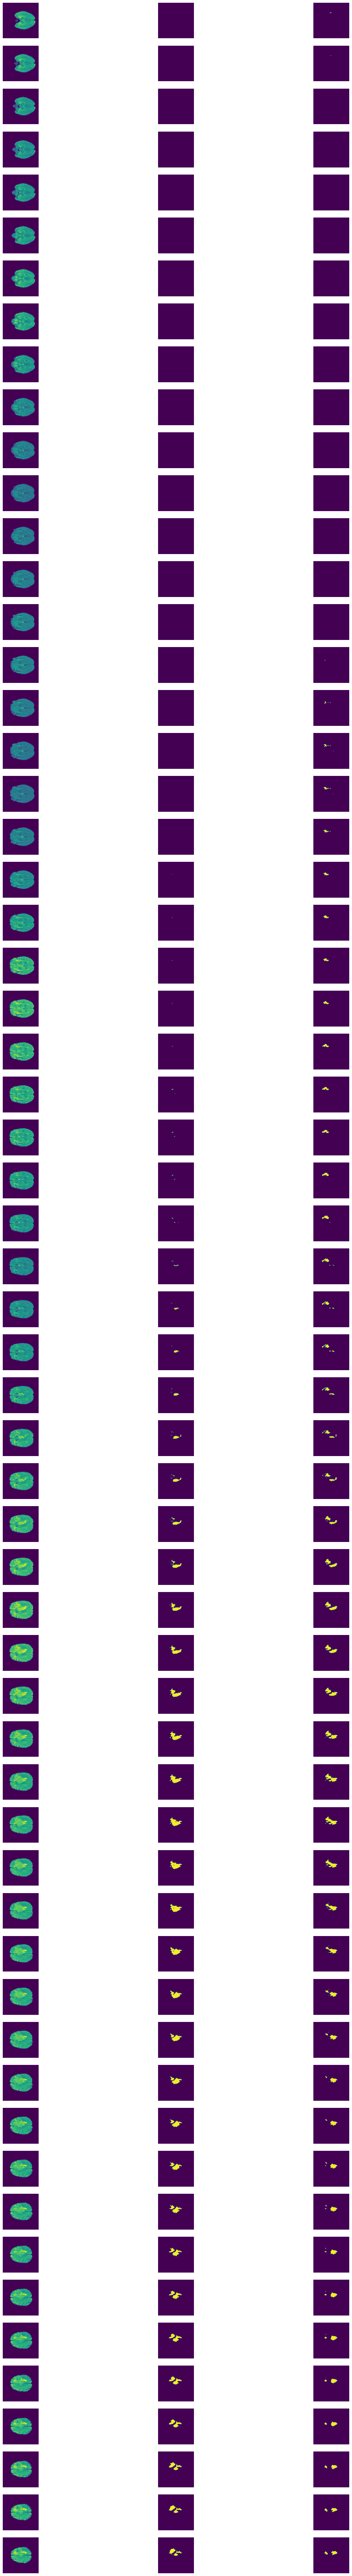

In [113]:
plot_results(UNet_1, 0)

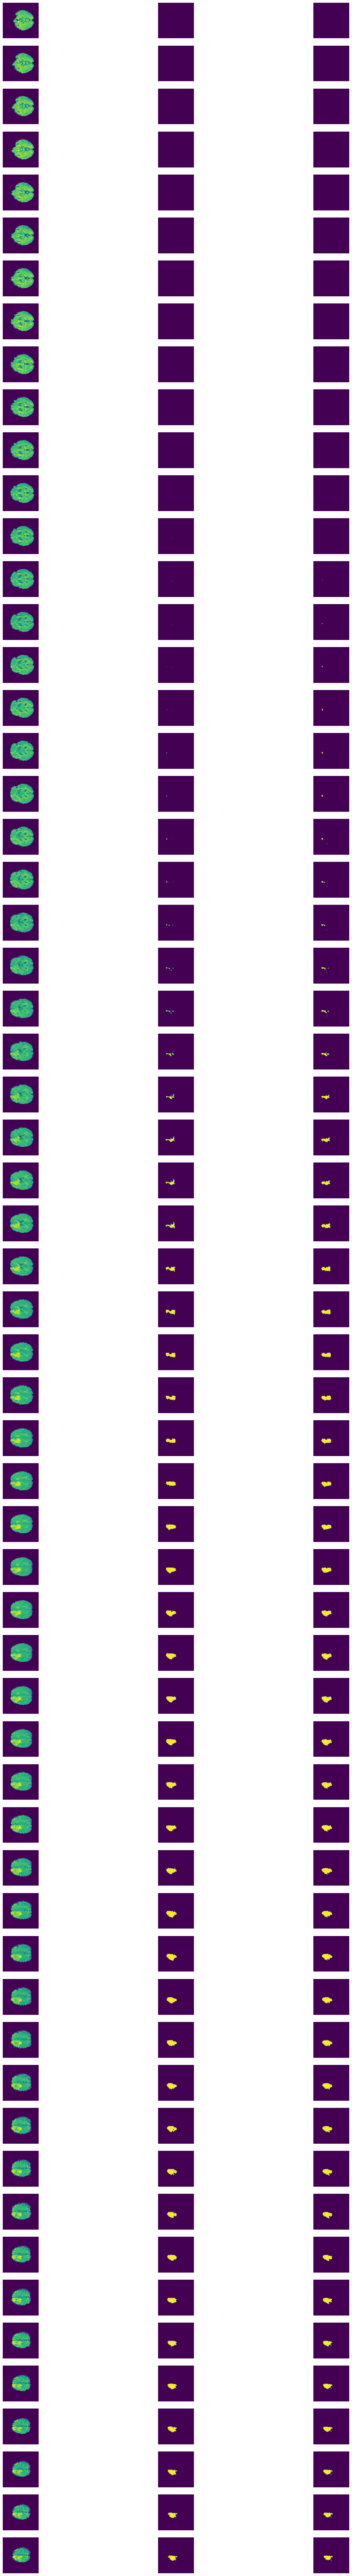

In [114]:
plot_results(UNet, 1)

In [ ]:
%%capture
UNet_2 = train_and_validate_model(nn.BCELoss(), files, epochs = 25)

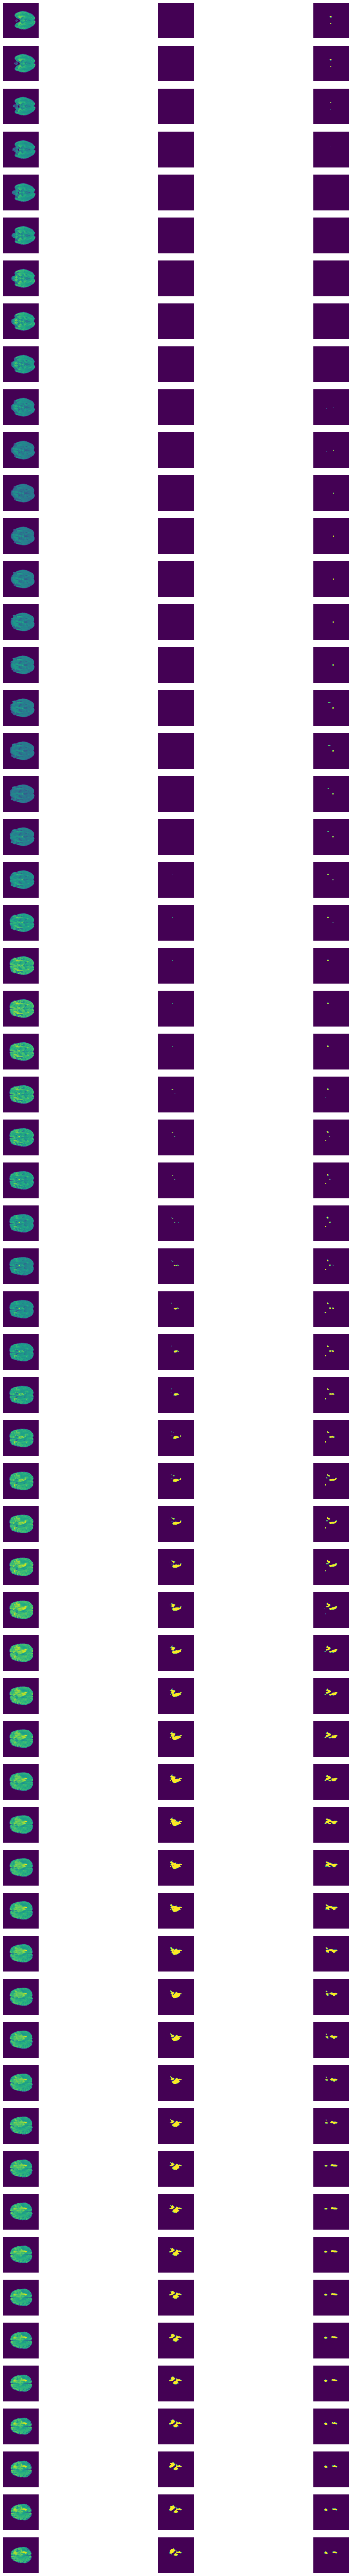

In [77]:
plot_results(UNet_1, 0)

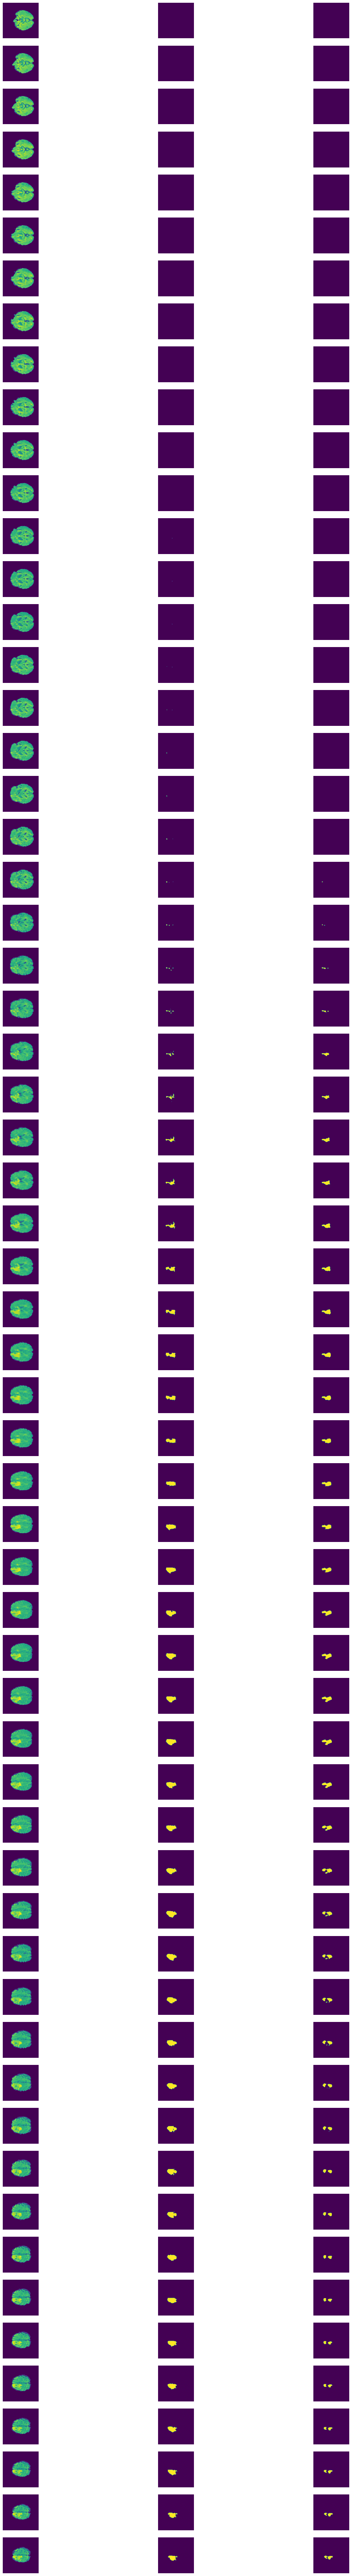

In [79]:
plot_results(UNet_1, 1)

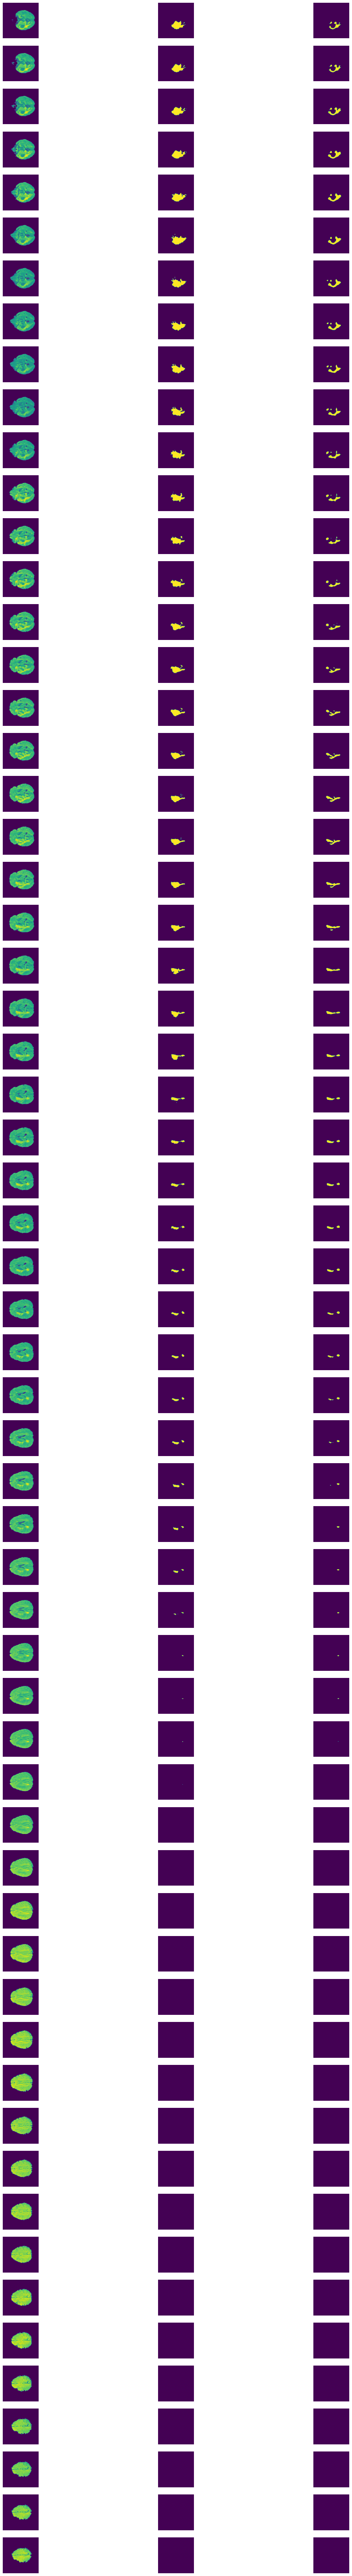

In [107]:
plot_results(UNet_1, 2)